In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
#%matplotlib notebook
#import matplotlib.pylab as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

import diffimTests as dit

3


In [2]:
# Set up console so we can reattach via terminal ipython later. See:
# https://stackoverflow.com/questions/19479645/using-ipython-console-along-side-ipython-notebook

%qtconsole

# Then do `ipython console --existing` in a terminal to connect and have access to same data!
# But note, do not do CTRL-D in that terminal or it will kill the kernel!

Here I re-wrote `runTest` to use `afwTable.matchXy()` for catalog matching (instead of my own matching).
The resulting numbers are slightly different. The old values were:
    
```
{'ZOGY': {'FP': 4, 'FN': 24, 'TP': 26}, 'ALstack': {'FP': 2, 'FN': 25, 'TP': 25}, 'SZOGY': {'FP': 4, 'FN': 24, 'TP': 26}, 'ALstack_decorr': {'FP': 5, 'FN': 25, 'TP': 25}}
```

In [3]:
reload(dit)
testObj = dit.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(500., 50),
                         templateNoNoise=True, skyLimited=True,
                        avoidAllOverlaps=15.)
res = testObj.runTest(returnSources=True, matchDist=np.sqrt(1.5))
src = res['sources']
del res['sources']
print res

{'ZOGY': {'FP': 1, 'FN': 14, 'TP': 36}, 'ALstack': {'FP': 1, 'FN': 16, 'TP': 34}, 'SZOGY': {'FP': 1, 'FN': 14, 'TP': 36}, 'ALstack_decorr': {'FP': 0, 'FN': 17, 'TP': 33}}


Do forced phot. now with funcs in diffimTests:

In [4]:
cats = testObj.doForcedPhot(transientsOnly=True)
sources, fp1, fp2, fp_ZOGY, fp_AL, fp_ALd = cats

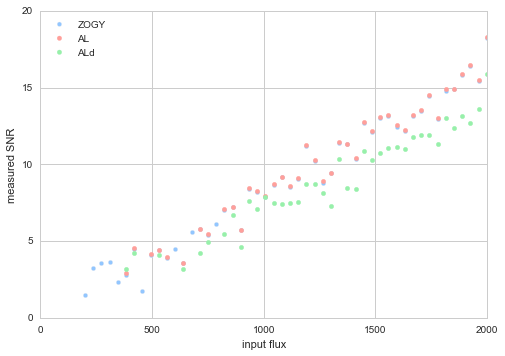

In [5]:
#%matplotlib notebook
plt.scatter(sources['inputFlux_science'], fp_ZOGY['base_PsfFlux_flux']/fp_ZOGY['base_PsfFlux_fluxSigma'], label='ZOGY')
plt.scatter(sources['inputFlux_science'], fp_AL['base_PsfFlux_flux']/fp_AL['base_PsfFlux_fluxSigma'], label='AL', color='r')
plt.scatter(sources['inputFlux_science'], fp_ALd['base_PsfFlux_flux']/fp_ALd['base_PsfFlux_fluxSigma'], label='ALd', color='g')
plt.legend(loc='upper left')
plt.xlabel('input flux')
plt.ylabel('measured SNR')
plt.xlim(0, 2000);

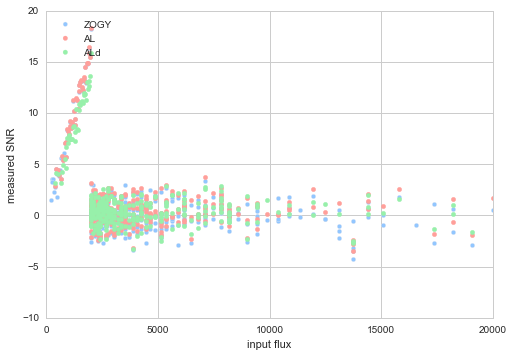

In [6]:
cats = testObj.doForcedPhot(transientsOnly=False)
sources, fp1, fp2, fp_ZOGY, fp_AL, fp_ALd = cats
#%matplotlib notebook
plt.scatter(sources['inputFlux_science'], fp_ZOGY['base_PsfFlux_flux']/fp_ZOGY['base_PsfFlux_fluxSigma'], label='ZOGY')
plt.scatter(sources['inputFlux_science'], fp_AL['base_PsfFlux_flux']/fp_AL['base_PsfFlux_fluxSigma'], label='AL', color='r')
plt.scatter(sources['inputFlux_science'], fp_ALd['base_PsfFlux_flux']/fp_ALd['base_PsfFlux_fluxSigma'], label='ALd', color='g')
plt.legend(loc='upper left')
plt.xlabel('input flux')
plt.ylabel('measured SNR')
plt.xlim(0, 20000);

Try to compute SNR directly using (a) source flux, (b) background variance, and (c) PSF...

In [7]:
flux = 750.
psf = testObj.im2.psf
sky = testObj.im2.sig**2
print sky

nPix = np.sum(psf/psf.max()) * 2.  # not sure where the 2 comes from but it works.
print nPix, np.pi*1.8*2.2*4  # and it equals pi*r1*r2*4.

def snr(flux, sky, psf, skyLimited=True):
    psf = psf / psf.max()
    nPix = np.sum(psf) * 2.
    if skyLimited:  #  only sky noise matters 
        return flux / (np.sqrt(nPix * sky))
    else:
        return flux / (np.sqrt(flux + nPix * sky))

print snr(flux, sky, psf)
print testObj.im2.calcSNR(flux, skyLimited=True)  # moved the func here.

299.955702233
49.7628276329 49.7628276329
6.13875325217
6.13875325217


0.999800888202


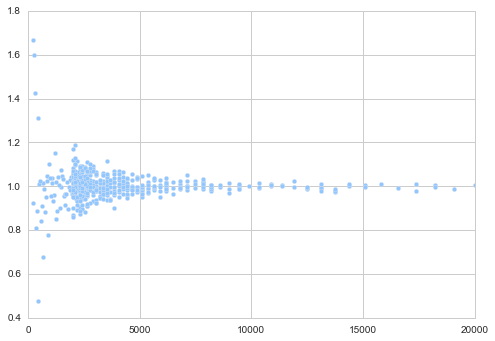

In [8]:
meas = fp2['base_PsfFlux_flux']/fp2['base_PsfFlux_fluxSigma']
calc = testObj.im2.calcSNR(sources['inputFlux_science'], skyLimited=True)
print np.median(meas/calc)
plt.scatter(sources['inputFlux_science'], meas/calc)
plt.xlim(0, 20000);

Figure out matching. Match sources detected in ZOGY diffim to input transients.

In [9]:
cats = testObj.doForcedPhot(transientsOnly=True)
sources, fp1, fp2, fp_ZOGY, fp_AL, fp_ALd = cats
dit.sizeme(dit.catalogToDF(sources).head())

,centroid_x,centroid_y,coord_dec,coord_ra,id,inputFlux_science,inputFlux_template,parent
0,190.250055,433.697910,0.927934,3.761633,1,1155.102041,0.0,0
1,139.374588,139.514874,0.928196,3.761555,2,1412.244898,0.0,0
2,462.770744,371.274741,0.927985,3.762038,3,567.346939,0.0,0
3,386.044611,212.919116,0.928127,3.761923,4,1595.918367,0.0,0
4,354.583822,118.725453,0.928212,3.761875,5,1338.775510,0.0,0


Cross-reference the *detections* in ZOGY (`src['ZOGY']`) with the input sources `sources` to identify which of the 50 input transients were detected.

In [10]:
import lsst.afw.table as afwTable
import lsst.afw.table.catalogMatches as catMatch
import lsst.daf.base as dafBase
reload(dit)

matches = afwTable.matchXy(sources, src['ZOGY'], 1.0)
print len(matches)

metadata = dafBase.PropertyList()
matchCat = catMatch.matchesToCatalog(matches, metadata)
tmp = dit.catalogToDF(matchCat)
dit.sizeme(tmp.head())

35


,distance,ref_centroid_x,ref_centroid_y,ref_coord_dec,ref_coord_ra,ref_id,ref_inputFlux_science,ref_inputFlux_template,ref_parent,src_base_CircularApertureFlux_12_0_flag,src_base_CircularApertureFlux_12_0_flag_apertureTruncated,src_base_CircularApertureFlux_12_0_flux,src_base_CircularApertureFlux_12_0_fluxSigma,src_base_CircularApertureFlux_17_0_flag,src_base_CircularApertureFlux_17_0_flag_apertureTruncated,src_base_CircularApertureFlux_17_0_flux,src_base_CircularApertureFlux_17_0_fluxSigma,src_base_CircularApertureFlux_25_0_flag,src_base_CircularApertureFlux_25_0_flag_apertureTruncated,src_base_CircularApertureFlux_25_0_flux,src_base_CircularApertureFlux_25_0_fluxSigma,src_base_CircularApertureFlux_35_0_flag,src_base_CircularApertureFlux_35_0_flag_apertureTruncated,src_base_CircularApertureFlux_35_0_flux,src_base_CircularApertureFlux_35_0_fluxSigma,src_base_CircularApertureFlux_3_0_flag,src_base_CircularApertureFlux_3_0_flag_apertureTruncated,src_base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_3_0_flux,src_base_CircularApertureFlux_3_0_fluxSigma,src_base_CircularApertureFlux_4_5_flag,src_base_CircularApertureFlux_4_5_flag_apertureTruncated,src_base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_4_5_flux,src_base_CircularApertureFlux_4_5_fluxSigma,src_base_CircularApertureFlux_50_0_flag,src_base_CircularApertureFlux_50_0_flag_apertureTruncated,src_base_CircularApertureFlux_50_0_flux,src_base_CircularApertureFlux_50_0_fluxSigma,src_base_CircularApertureFlux_6_0_flag,src_base_CircularApertureFlux_6_0_flag_apertureTruncated,src_base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_6_0_flux,src_base_CircularApertureFlux_6_0_fluxSigma,src_base_CircularApertureFlux_70_0_flag,src_base_CircularApertureFlux_70_0_flag_apertureTruncated,src_base_CircularApertureFlux_70_0_flux,src_base_CircularApertureFlux_70_0_fluxSigma,src_base_CircularApertureFlux_9_0_flag,src_base_CircularApertureFlux_9_0_flag_apertureTruncated,src_base_CircularApertureFlux_9_0_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_9_0_flux,src_base_CircularApertureFlux_9_0_fluxSigma,src_base_GaussianCentroid_flag,src_base_GaussianCentroid_flag_noPeak,src_base_GaussianCentroid_flag_resetToPeak,src_base_GaussianCentroid_x,src_base_GaussianCentroid_y,src_base_GaussianFlux_flag,src_base_GaussianFlux_flux,src_base_GaussianFlux_fluxSigma,src_base_NaiveCentroid_flag,src_base_NaiveCentroid_flag_edge,src_base_NaiveCentroid_flag_noCounts,src_base_NaiveCentroid_flag_resetToPeak,src_base_NaiveCentroid_x,src_base_NaiveCentroid_y,src_base_PeakCentroid_flag,src_base_PeakCentroid_x,src_base_PeakCentroid_y,src_base_PeakLikelihoodFlux_flag,src_base_PeakLikelihoodFlux_flux,src_base_PeakLikelihoodFlux_fluxSigma,src_base_PixelFlags_flag,src_base_PixelFlags_flag_bad,src_base_PixelFlags_flag_cr,src_base_PixelFlags_flag_crCenter,src_base_PixelFlags_flag_edge,src_base_PixelFlags_flag_interpolated,src_base_PixelFlags_flag_interpolatedCenter,src_base_PixelFlags_flag_offimage,src_base_PixelFlags_flag_saturated,src_base_PixelFlags_flag_saturatedCenter,src_base_PixelFlags_flag_suspect,src_base_PixelFlags_flag_suspectCenter,src_base_PsfFlux_flag,src_base_PsfFlux_flag_edge,src_base_PsfFlux_flag_noGoodPixels,src_base_PsfFlux_flux,src_base_PsfFlux_fluxSigma,src_base_SdssCentroid_flag,src_base_SdssCentroid_flag_almostNoSecondDerivative,src_base_SdssCentroid_flag_edge,src_base_SdssCentroid_flag_noSecondDerivative,src_base_SdssCentroid_flag_notAtMaximum,src_base_SdssCentroid_flag_resetToPeak,src_base_SdssCentroid_x,src_base_SdssCentroid_xSigma,src_base_SdssCentroid_y,src_base_SdssCentroid_ySigma,src_base_SdssShape_flag,src_base_SdssShape_flag_maxIter,src_base_SdssShape_flag_psf,src_base_SdssShape_flag_shift,src_base_SdssShape_flag_unweighted,src_base_SdssShape_flag_unweightedBad,src_base_SdssShape_flux,src_base_SdssShape_fluxSigma,src_base_SdssShape_flux_xx_Cov,src_base_SdssShape_flux_xy_Cov,src_base_Sds

OK, we can cross-ref the `ref_id` of `matchesCat` with `id` of `sources`.

In [11]:
dit.sizeme(tmp[np.in1d(tmp['ref_id'], [1,2,3,4,5])])

,distance,ref_centroid_x,ref_centroid_y,ref_coord_dec,ref_coord_ra,ref_id,ref_inputFlux_science,ref_inputFlux_template,ref_parent,src_base_CircularApertureFlux_12_0_flag,src_base_CircularApertureFlux_12_0_flag_apertureTruncated,src_base_CircularApertureFlux_12_0_flux,src_base_CircularApertureFlux_12_0_fluxSigma,src_base_CircularApertureFlux_17_0_flag,src_base_CircularApertureFlux_17_0_flag_apertureTruncated,src_base_CircularApertureFlux_17_0_flux,src_base_CircularApertureFlux_17_0_fluxSigma,src_base_CircularApertureFlux_25_0_flag,src_base_CircularApertureFlux_25_0_flag_apertureTruncated,src_base_CircularApertureFlux_25_0_flux,src_base_CircularApertureFlux_25_0_fluxSigma,src_base_CircularApertureFlux_35_0_flag,src_base_CircularApertureFlux_35_0_flag_apertureTruncated,src_base_CircularApertureFlux_35_0_flux,src_base_CircularApertureFlux_35_0_fluxSigma,src_base_CircularApertureFlux_3_0_flag,src_base_CircularApertureFlux_3_0_flag_apertureTruncated,src_base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_3_0_flux,src_base_CircularApertureFlux_3_0_fluxSigma,src_base_CircularApertureFlux_4_5_flag,src_base_CircularApertureFlux_4_5_flag_apertureTruncated,src_base_CircularApertureFlux_4_5_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_4_5_flux,src_base_CircularApertureFlux_4_5_fluxSigma,src_base_CircularApertureFlux_50_0_flag,src_base_CircularApertureFlux_50_0_flag_apertureTruncated,src_base_CircularApertureFlux_50_0_flux,src_base_CircularApertureFlux_50_0_fluxSigma,src_base_CircularApertureFlux_6_0_flag,src_base_CircularApertureFlux_6_0_flag_apertureTruncated,src_base_CircularApertureFlux_6_0_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_6_0_flux,src_base_CircularApertureFlux_6_0_fluxSigma,src_base_CircularApertureFlux_70_0_flag,src_base_CircularApertureFlux_70_0_flag_apertureTruncated,src_base_CircularApertureFlux_70_0_flux,src_base_CircularApertureFlux_70_0_fluxSigma,src_base_CircularApertureFlux_9_0_flag,src_base_CircularApertureFlux_9_0_flag_apertureTruncated,src_base_CircularApertureFlux_9_0_flag_sincCoeffsTruncated,src_base_CircularApertureFlux_9_0_flux,src_base_CircularApertureFlux_9_0_fluxSigma,src_base_GaussianCentroid_flag,src_base_GaussianCentroid_flag_noPeak,src_base_GaussianCentroid_flag_resetToPeak,src_base_GaussianCentroid_x,src_base_GaussianCentroid_y,src_base_GaussianFlux_flag,src_base_GaussianFlux_flux,src_base_GaussianFlux_fluxSigma,src_base_NaiveCentroid_flag,src_base_NaiveCentroid_flag_edge,src_base_NaiveCentroid_flag_noCounts,src_base_NaiveCentroid_flag_resetToPeak,src_base_NaiveCentroid_x,src_base_NaiveCentroid_y,src_base_PeakCentroid_flag,src_base_PeakCentroid_x,src_base_PeakCentroid_y,src_base_PeakLikelihoodFlux_flag,src_base_PeakLikelihoodFlux_flux,src_base_PeakLikelihoodFlux_fluxSigma,src_base_PixelFlags_flag,src_base_PixelFlags_flag_bad,src_base_PixelFlags_flag_cr,src_base_PixelFlags_flag_crCenter,src_base_PixelFlags_flag_edge,src_base_PixelFlags_flag_interpolated,src_base_PixelFlags_flag_interpolatedCenter,src_base_PixelFlags_flag_offimage,src_base_PixelFlags_flag_saturated,src_base_PixelFlags_flag_saturatedCenter,src_base_PixelFlags_flag_suspect,src_base_PixelFlags_flag_suspectCenter,src_base_PsfFlux_flag,src_base_PsfFlux_flag_edge,src_base_PsfFlux_flag_noGoodPixels,src_base_PsfFlux_flux,src_base_PsfFlux_fluxSigma,src_base_SdssCentroid_flag,src_base_SdssCentroid_flag_almostNoSecondDerivative,src_base_SdssCentroid_flag_edge,src_base_SdssCentroid_flag_noSecondDerivative,src_base_SdssCentroid_flag_notAtMaximum,src_base_SdssCentroid_flag_resetToPeak,src_base_SdssCentroid_x,src_base_SdssCentroid_xSigma,src_base_SdssCentroid_y,src_base_SdssCentroid_ySigma,src_base_SdssShape_flag,src_base_SdssShape_flag_maxIter,src_base_SdssShape_flag_psf,src_base_SdssShape_flag_shift,src_base_SdssShape_flag_unweighted,src_base_SdssShape_flag_unweightedBad,src_base_SdssShape_flux,src_base_SdssShape_fluxSigma,src_base_SdssShape_flux_xx_Cov,src_base_SdssShape_flux_xy_Cov,src_base_Sds

In [12]:
def plotWithDetectionsHighlighted(testObj, transientsOnly=True, addPresub=False, 
                                  xaxisIsScienceForcedPhot=False, alpha=0.5):
    
    #fp_DIFFIM=fp_ZOGY, label='ZOGY', color='b', alpha=1.0,
    
    res = testObj.runTest(returnSources=True, matchDist=np.sqrt(1.5))
    src = res['sources']
    del res['sources']
    print res
    
    cats = testObj.doForcedPhot(transientsOnly=transientsOnly)
    sources, fp1, fp2, fp_ZOGY, fp_AL, fp_ALd = cats

    # if xaxisIsScienceForcedPhot is True, then don't use sources['inputFlux_science'] --
    #    use fp2['base_PsfFlux_flux'] instead.
    if not xaxisIsScienceForcedPhot:
        srces = sources['inputFlux_science']
    else:
        srces = fp2['base_PsfFlux_flux']
        
    df = pd.DataFrame()
    df['inputFlux'] = sources['inputFlux_science']
    df['templateFlux'] = fp1['base_PsfFlux_flux']
    df['scienceFlux'] = fp2['base_PsfFlux_flux']
    df['inputId'] = sources['id']
    df['inputCentroid_x'] = sources['centroid_x']
    df['inputCentroid_y'] = sources['centroid_y']
    
    fp_DIFFIM = [fp_ZOGY, fp_AL, fp_ALd]
    label = ['ZOGY', 'ALstack', 'ALstack_decorr']
    color = ['b', 'r', 'g']
    
    for i, fp_d in enumerate(fp_DIFFIM):
        df[label[i] + '_SNR'] = fp_d['base_PsfFlux_flux']/fp_d['base_PsfFlux_fluxSigma']

        plt.scatter(srces, 
                    fp_d['base_PsfFlux_flux']/fp_d['base_PsfFlux_fluxSigma'], 
                    color=color[i], alpha=alpha, label=None, s=10)
        plt.scatter(srces, 
                    fp_d['base_PsfFlux_flux']/fp_d['base_PsfFlux_fluxSigma'], 
                    color='k', marker='x', alpha=alpha, label=None, s=10)

        if not xaxisIsScienceForcedPhot:
            matches = afwTable.matchXy(sources, src[label[i]], 1.0)
            metadata = dafBase.PropertyList()
            matchCat = catMatch.matchesToCatalog(matches, metadata)
            sources_detected = dit.catalogToDF(sources)
            detected = np.in1d(sources_detected['id'], matchCat['ref_id'])
            sources_detected = sources_detected[detected]
            sources_detected = sources_detected['inputFlux_science']
            fp_ZOGY_detected = dit.catalogToDF(fp_d)
            detected = np.in1d(fp_ZOGY_detected['id'], matchCat['ref_id'])
            fp_ZOGY_detected = fp_ZOGY_detected[detected]
        else:
            matches = afwTable.matchXy(fp2, src[label[i]], 1.0)
            metadata = dafBase.PropertyList()
            matchCat = catMatch.matchesToCatalog(matches, metadata)
            sources_detected = dit.catalogToDF(fp2)
            detected = np.in1d(sources_detected['id'], matchCat['ref_id'])
            sources_detected = sources_detected[detected]
            sources_detected = sources_detected['base_PsfFlux_flux']
            fp_ZOGY_detected = dit.catalogToDF(fp_d)
            detected = np.in1d(fp_ZOGY_detected['id'], matchCat['ref_id'])
            fp_ZOGY_detected = fp_ZOGY_detected[detected]

        df[label[i] + '_detected'] = detected
        plt.scatter(sources_detected, 
                    fp_ZOGY_detected['base_PsfFlux_flux']/fp_ZOGY_detected['base_PsfFlux_fluxSigma'], 
                    label=label[i], s=20, color=color[i], alpha=alpha) #, edgecolors='r')
    
    if addPresub: # Add measurements in original science and template images
        df['templateSNR'] = fp1['base_PsfFlux_flux']/fp1['base_PsfFlux_fluxSigma']
        plt.scatter(srces, 
                    fp1['base_PsfFlux_flux']/fp1['base_PsfFlux_fluxSigma'], 
                    label='template', color='y', alpha=alpha)
        df['scienceSNR'] = fp2['base_PsfFlux_flux']/fp2['base_PsfFlux_fluxSigma']
        plt.scatter(srces, 
                    fp2['base_PsfFlux_flux']/fp2['base_PsfFlux_fluxSigma'], 
                    label='science', color='orange', alpha=alpha-0.2)
        
    snrCalced = testObj.im2.calcSNR(sources['inputFlux_science'], skyLimited=True)
    df['inputSNR'] = snrCalced
    plt.scatter(srces, snrCalced, color='k', alpha=alpha-0.2, s=7, label='Input SNR')
    plt.scatter([10000], [10], color='k', marker='x', label='Missed')
    plt.legend(loc='upper left', scatterpoints=3)
    if not xaxisIsScienceForcedPhot:
        plt.xlabel('input flux')
    else:
        plt.xlabel('science flux (measured)')
    plt.ylabel('measured SNR')

    return df

Re-do with new `avoidAllOverlaps` option set to an avoidance radius of 5.

In [13]:
## Just re-create the testObj here:
reload(dit)
testObj = dit.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(500., 50),
                         templateNoNoise=True, skyLimited=True,
                         avoidAllOverlaps=5.)

{'ZOGY': {'FP': 0, 'FN': 20, 'TP': 30}, 'ALstack': {'FP': 0, 'FN': 22, 'TP': 28}, 'SZOGY': {'FP': 3, 'FN': 22, 'TP': 28}, 'ALstack_decorr': {'FP': 0, 'FN': 21, 'TP': 29}}


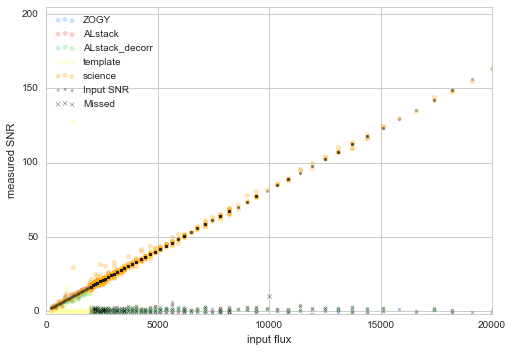

In [14]:
plotWithDetectionsHighlighted(testObj, transientsOnly=False, addPresub=True)
plt.xlim(0, 20010)
plt.ylim(-2, 205);

{'ZOGY': {'FP': 0, 'FN': 20, 'TP': 30}, 'ALstack': {'FP': 0, 'FN': 22, 'TP': 28}, 'SZOGY': {'FP': 3, 'FN': 22, 'TP': 28}, 'ALstack_decorr': {'FP': 0, 'FN': 21, 'TP': 29}}


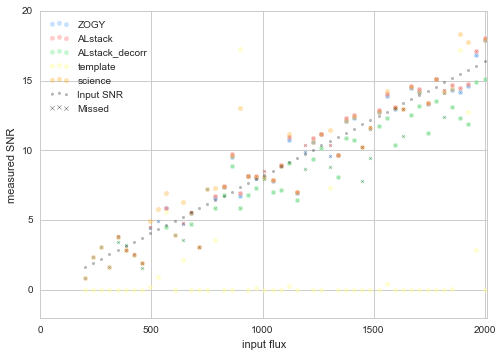

In [15]:
#%matplotlib notebook
df = plotWithDetectionsHighlighted(testObj, transientsOnly=True, addPresub=True)
plt.xlim(0, 2010)
plt.ylim(-2, 20);

Take a look at the apparently "anomalous" points... Well, using a radius of 15 got rid of all anomalous points! The below is what we would do if we used an exclusion radius of 5 instead...

In [16]:
tmp = df.ix[(df.scienceSNR > 12) & (df.scienceSNR < 15) & (df.inputFlux < 1000)]
dit.sizeme(tmp)

,inputFlux,templateFlux,scienceFlux,inputId,inputCentroid_x,inputCentroid_y,ZOGY_SNR,ZOGY_detected,ALstack_SNR,ALstack_detected,ALstack_decorr_SNR,ALstack_decorr_detected,templateSNR,scienceSNR,inputSNR
44,897.959184,126.694082,1584.926085,45,56.655724,243.743111,6.75629,True,6.976388,True,5.865888,True,17.258848,13.025628,7.350662


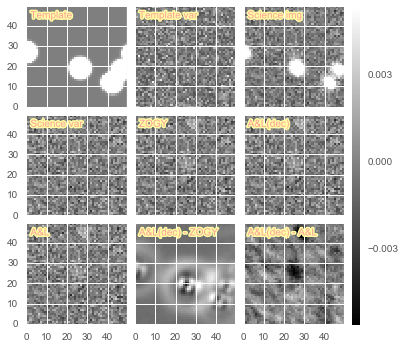

In [17]:
testObj.doPlot(centroidCoord=[tmp.inputCentroid_y.values[0], tmp.inputCentroid_x.values[0]]);

Re-do with new `avoidAllOverlaps` option set to an avoidance radius of 15. (That's big!)

In [18]:
## Just re-create the testObj here:
reload(dit)
testObj = dit.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(500., 50),
                         templateNoNoise=True, skyLimited=True,
                         avoidAllOverlaps=15.)

{'ZOGY': {'FP': 1, 'FN': 14, 'TP': 36}, 'ALstack': {'FP': 1, 'FN': 16, 'TP': 34}, 'SZOGY': {'FP': 1, 'FN': 14, 'TP': 36}, 'ALstack_decorr': {'FP': 0, 'FN': 17, 'TP': 33}}


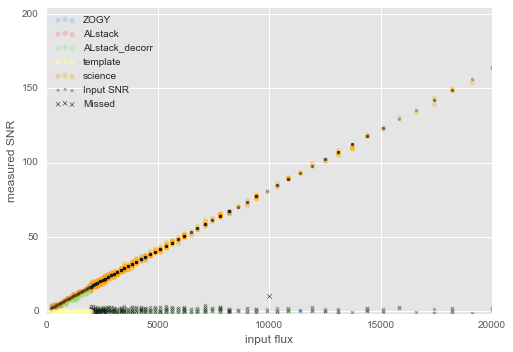

In [19]:
plotWithDetectionsHighlighted(testObj, transientsOnly=False, addPresub=True)
plt.xlim(0, 20010)
plt.ylim(-2, 205);

{'ZOGY': {'FP': 1, 'FN': 14, 'TP': 36}, 'ALstack': {'FP': 1, 'FN': 16, 'TP': 34}, 'SZOGY': {'FP': 1, 'FN': 14, 'TP': 36}, 'ALstack_decorr': {'FP': 0, 'FN': 17, 'TP': 33}}


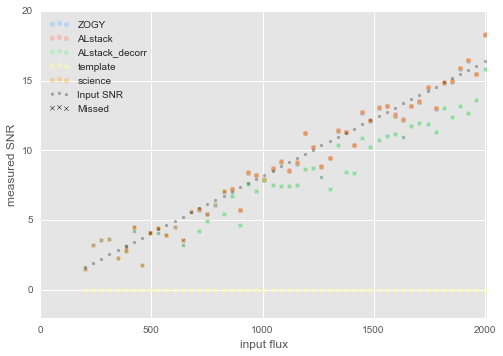

In [20]:
#%matplotlib notebook
df = plotWithDetectionsHighlighted(testObj, transientsOnly=True, addPresub=True)
plt.xlim(0, 2010)
plt.ylim(-2, 20);

Looks like `avoidAllOverlaps = 15` removes all anomalies. Yay!

Where are the ZOGY points? Are they there? I think they're all on top of the A&L points.

In [21]:
dit.sizeme(df.head())

,inputFlux,templateFlux,scienceFlux,inputId,inputCentroid_x,inputCentroid_y,ZOGY_SNR,ZOGY_detected,ALstack_SNR,ALstack_detected,ALstack_decorr_SNR,ALstack_decorr_detected,templateSNR,scienceSNR,inputSNR
0,1155.102041,0.000054,1102.791523,1,190.250055,433.697910,9.044542,True,9.134816,True,7.511924,True,7.566012e-06,9.064953,9.454515
1,1412.244898,0.000035,1261.328456,2,139.374588,139.514874,10.370479,True,10.411796,True,8.361895,True,4.508992e-06,10.392740,11.559231
2,567.346939,0.000001,477.147947,3,462.770744,371.274741,3.902983,False,3.936384,False,NaN,False,1.740220e-07,3.912671,4.643737
3,1595.918367,0.000020,1518.427955,4,386.044611,212.919116,12.433699,True,12.576368,True,11.147544,True,2.528548e-06,12.464857,13.062599
4,1338.775510,0.000058,1387.953441,5,354.583822,118.725453,11.386410,True,11.443124,True,10.373004,True,6.759740e-06,11.421599,10.957883


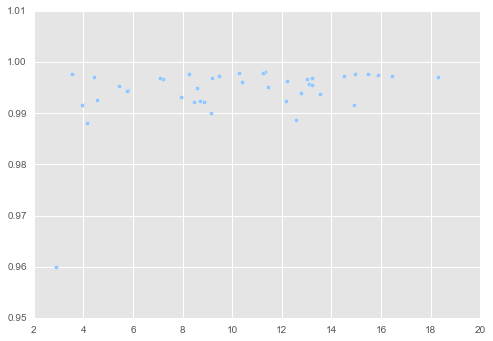

In [22]:
plt.scatter(df.ALstack_SNR, df.ZOGY_SNR / df.ALstack_SNR)

{'ZOGY': {'FP': 1, 'FN': 14, 'TP': 36}, 'ALstack': {'FP': 1, 'FN': 16, 'TP': 34}, 'SZOGY': {'FP': 1, 'FN': 14, 'TP': 36}, 'ALstack_decorr': {'FP': 0, 'FN': 17, 'TP': 33}}


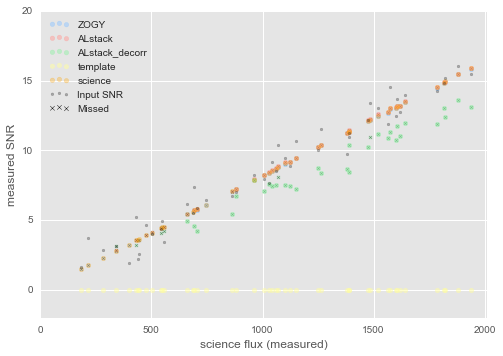

In [23]:
#%matplotlib notebook
plotWithDetectionsHighlighted(testObj, transientsOnly=True, addPresub=True,
                              xaxisIsScienceForcedPhot=True)
plt.xlim(0, 2010)
plt.ylim(-2, 20);

Re-do with all ~5-sigma sources, and no static sources. Just for fun.

Actually, this would compltely *foobar* the AL results, so add a few static sources.
Looks like A&L fails often with `n_sources` below around 100.

That would be transient fluxes of ~750 if `templateNoNoise=False` or ~650 if it's `True`.

In [24]:
reload(dit)
testObj2 = dit.DiffimTest(n_sources=91, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.repeat(750., 50),
                         templateNoNoise=True, skyLimited=True,
                         avoidAllOverlaps=15.)

{'ZOGY': {'FP': 5, 'FN': 14, 'TP': 36}, 'ALstack': {'FP': 5, 'FN': 23, 'TP': 27}, 'SZOGY': {'FP': 10, 'FN': 17, 'TP': 33}, 'ALstack_decorr': {'FP': 5, 'FN': 23, 'TP': 27}}


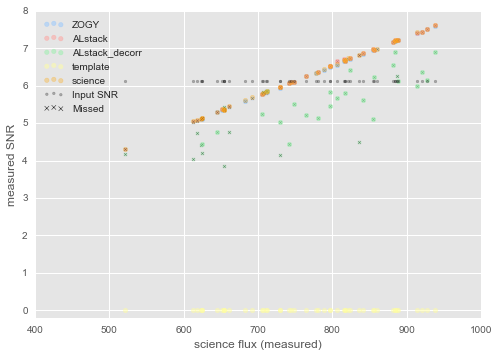

In [25]:
plotWithDetectionsHighlighted(testObj2, transientsOnly=True, addPresub=True,
                              xaxisIsScienceForcedPhot=True)
plt.xlim(400, 1000)
plt.ylim(-0.2, 8);

In [26]:
print testObj2.im1.sig, testObj2.im2.sig
print dit.computeClippedImageStats(testObj2.im1.var)
print dit.computeClippedImageStats(testObj2.im1.im)

1.40509451886 17.3191298111
(1.9742906069347554, 1.3696862561694534, 0.0, 11.0)
(0.75434670429246642, 12.857024987455009, 0.0, 1126.0383074952927)


Try it with `templateNoNoise=False` to see if `ALstack_decorr` works correctly in this case.

In [27]:
reload(dit)
testObj3 = dit.DiffimTest(n_sources=100, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.repeat(750., 50),
                         templateNoNoise=False, skyLimited=False,
                         avoidAllOverlaps=5.)

{'ZOGY': {'FP': 3, 'FN': 35, 'TP': 15}, 'ALstack': {'FP': 0, 'FN': 44, 'TP': 6}, 'SZOGY': {'FP': 7, 'FN': 42, 'TP': 8}, 'ALstack_decorr': {'FP': 1, 'FN': 40, 'TP': 10}}


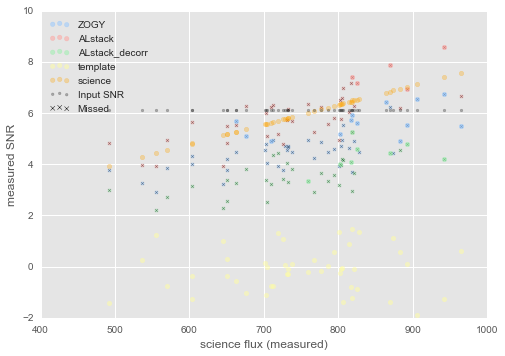

In [28]:
plotWithDetectionsHighlighted(testObj3, transientsOnly=True, addPresub=True,
                                  xaxisIsScienceForcedPhot=True)
plt.xlim(400, 1000)
plt.ylim(-2, 10);